<a href="https://colab.research.google.com/github/kimdahyeon977/HowToSolveInbalance/blob/main/weather_forecast(SMOTE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME ='kaggle'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/kaggle


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [ ]:
#시각화
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.dpi']=100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style='whitegrid')
%matplotlib inline

In [ ]:
#머신러닝
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

In [ ]:
train_a=pd.read_csv("comp_datasets_train/region_A_train.csv")
train_b=pd.read_csv("comp_datasets_train/region_B_train.csv")
train_c=pd.read_csv("comp_datasets_train/region_C_train.csv")
train_d=pd.read_csv("comp_datasets_train/region_D_train.csv")
train_e=pd.read_csv("comp_datasets_train/region_E_train.csv")

test_a=pd.read_csv("comp_datasets_test/region_A_test.csv")
test_b=pd.read_csv("comp_datasets_test/region_B_test.csv")
test_c=pd.read_csv("comp_datasets_test/region_C_test.csv")
test_d=pd.read_csv("comp_datasets_test/region_D_test.csv")
test_e=pd.read_csv("comp_datasets_test/region_E_test.csv")

labels_df=pd.read_csv("comp_datasets_train/solution_train.csv")

In [ ]:
#Exploratory Data Analysis
#데이터를 분석하기 위해 어떻게 가공할지 insight를 얻어보자
train_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     566 non-null    object 
 1   avg.temp                 566 non-null    float64
 2   max.temp                 566 non-null    float64
 3   min.temp                 566 non-null    float64
 4   precipitation            566 non-null    float64
 5   avg.wind.speed           566 non-null    float64
 6   max.wind.speed           566 non-null    float64
 7   max.wind.speed.dir       566 non-null    object 
 8   max.inst.wind.speed      566 non-null    float64
 9   max.inst.wind.speed.dir  566 non-null    object 
 10  min.atmos.pressure       566 non-null    float64
dtypes: float64(8), object(3)
memory usage: 48.8+ KB


In [ ]:
#모든 지역 데이터는 기본 키 date를 공유하므로 pandas에서 연결하고 concat()키를 지역 이름으로 설정할 수 있습니다.
train_all=pd.concat([train_a, train_b, train_c, train_d, train_e],keys=["A","B","C","D","E"])
train_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    229b70a3       3.3      10.2      -2.4            0.0             2.9   
  1    3134f4ff       5.7      13.7      -2.9            0.0             3.6   
  2    dbfaf910      13.8      20.0       9.0            0.0             5.3   
  3    3aea0cf0      11.4      19.3       5.8            0.0             4.2   
  4    f0227f56       2.4       7.7       0.3           43.5             0.9   
...         ...       ...       ...       ...            ...             ...   
E 561  91b2797d       6.3      13.1       0.3            0.0             0.6   
  562  b807fd87       6.2      13.5       0.3            0.0             0.8   
  563  8e0a48e0       9.0      15.9       2.4            0.0             0.6   
  564  9df85983       5.3      13.9       0.1            0.0             1.0   
  565  c9d4fe7c       6.4      15.3      -0.2            0.0             0.7   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0               9.3                  W                 14.3   
  1              10.7                  W                 15.8   
  2               9.4                 SW                 15.2   
  3              10.1                 SW                 20.6   
  4               3.7                 SW                  5.7   
...               ...                ...                  ...   
E 561             2.2                  S                  4.3   
  562             2.3                 SW                  6.3   
  563             2.4                 NW                  5.7   
  564             3.0                  S                  6.9   
  565             2.1                 NW                  5.5   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                         W              1015.1  
  1                         W              1011.3  
  2                         W              1004.2  
  3                        SW              1001.7  
  4                        SW              1003.5  
...                       ...                 ...  
E 561                       S                 NaN  
  562                       W                 NaN  
  563                       W                 NaN  
  564                      NW                 NaN  
  565                       N                 NaN  

[2830 rows x 11 columns]

In [ ]:
test_all=pd.concat([test_a, test_b, test_c, test_d, test_e],keys=["A","B","C","D","E"])
test_all

date  avg.temp  max.temp  min.temp  precipitation  avg.wind.speed  \
A 0    b92d713a       5.0      11.9       0.7            0.0             3.6   
  1    18817005       2.9       9.1      -1.8            0.0             3.4   
  2    8e19dc3c       9.8      18.9       0.4            0.0             3.1   
  3    6f0929dc      13.4      21.2       6.1            0.0             3.4   
  4    c7506622       9.1      16.3       2.4            0.0             2.7   
...         ...       ...       ...       ...            ...             ...   
E 373  01a1b150       6.9       9.5       4.3            1.5             0.3   
  374  90b49549       6.5      15.8      -0.1            0.0             0.6   
  375  15bc4979       7.9      10.3       3.5            9.5             0.3   
  376  b4104846       9.1      17.1       4.9           11.0             0.6   
  377  28c40b9c       7.0      17.1       0.6            0.0             0.8   

       max.wind.speed max.wind.speed.dir  max.inst.wind.speed  \
A 0              11.9                 NW                 16.7   
  1               9.6                 SW                 15.4   
  2               8.9                  W                 13.6   
  3               8.8                 SW                 13.8   
  4               7.6                 NW                 11.9   
...               ...                ...                  ...   
E 373             1.2                  S                  2.7   
  374             2.2                 SE                  4.7   
  375             1.7                 SW                  5.8   
  376             2.1                 SW                  5.8   
  377             2.8                  S                  5.2   

      max.inst.wind.speed.dir  min.atmos.pressure  
A 0                        NW              1009.2  
  1                        SW              1013.6  
  2                         W              1002.6  
  3                        SW              1003.1  
  4                        NW              1011.9  
...                       ...                 ...  
E 373                      SE                 NaN  
  374                       S                 NaN  
  375                       S                 NaN  
  376                      NW                 NaN  
  377                       S                 NaN  

[1890 rows x 11 columns]

In [ ]:
#원하는 인덱스에 맞게 가공한다.
train_all_lvls = train_all.reset_index()
train_all_lvls.rename(columns={"level_0":"region"},inplace=True) #첫번째행을 regino으로 재명
train_all_lvls.drop(columns=['level_1'], inplace=True) #두번째 행은 그냥 버리기
train_all_lvls.head()


,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.1
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.3
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.2
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.7
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.5


In [ ]:
#원하는 인덱스에 맞게 가공한다.
test_all_lvls = test_all.reset_index()
test_all_lvls.rename(columns={"level_0":"region"},inplace=True) #첫번째행을 regino으로 재명
test_all_lvls.drop(columns=['level_1'], inplace=True) #두번째 행은 그냥 버리기
test_all_lvls.head()

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,b92d713a,5.0,11.9,0.7,0.0,3.6,11.9,NW,16.7,NW,1009.2
1,A,18817005,2.9,9.1,-1.8,0.0,3.4,9.6,SW,15.4,SW,1013.6
2,A,8e19dc3c,9.8,18.9,0.4,0.0,3.1,8.9,W,13.6,W,1002.6
3,A,6f0929dc,13.4,21.2,6.1,0.0,3.4,8.8,SW,13.8,SW,1003.1
4,A,c7506622,9.1,16.3,2.4,0.0,2.7,7.6,NW,11.9,NW,1011.9


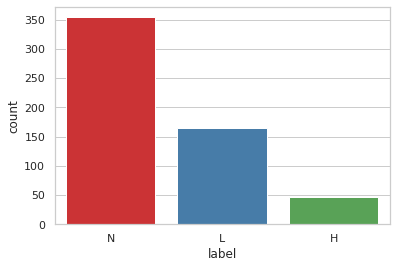

In [ ]:
#데이터에 대한 직관을 얻고 분석 방향성을 잡기위해 시각화를 먼저한다.
sns.countplot(x='label',data=labels_df,palette="Set1") #정답 data를 시각화해보자

In [ ]:
#클래스 수가 불균형이 심하면 그냥 N일거라고 찍어도 정답일 확률이 높기때문에 레이블 N이 다른 클래스보다 더 많이 예측된다.
#이 점을 염두에 두고 더 좋은 직관을 얻을때까지 시각화를 진행해보자

In [ ]:
#지역별로 특징 그리기
train_all_lvls.columns[2:]

Index(['avg.temp', 'max.temp', 'min.temp', 'precipitation', 'avg.wind.speed',
       'max.wind.speed', 'max.wind.speed.dir', 'max.inst.wind.speed',
       'max.inst.wind.speed.dir', 'min.atmos.pressure'],
      dtype='object')

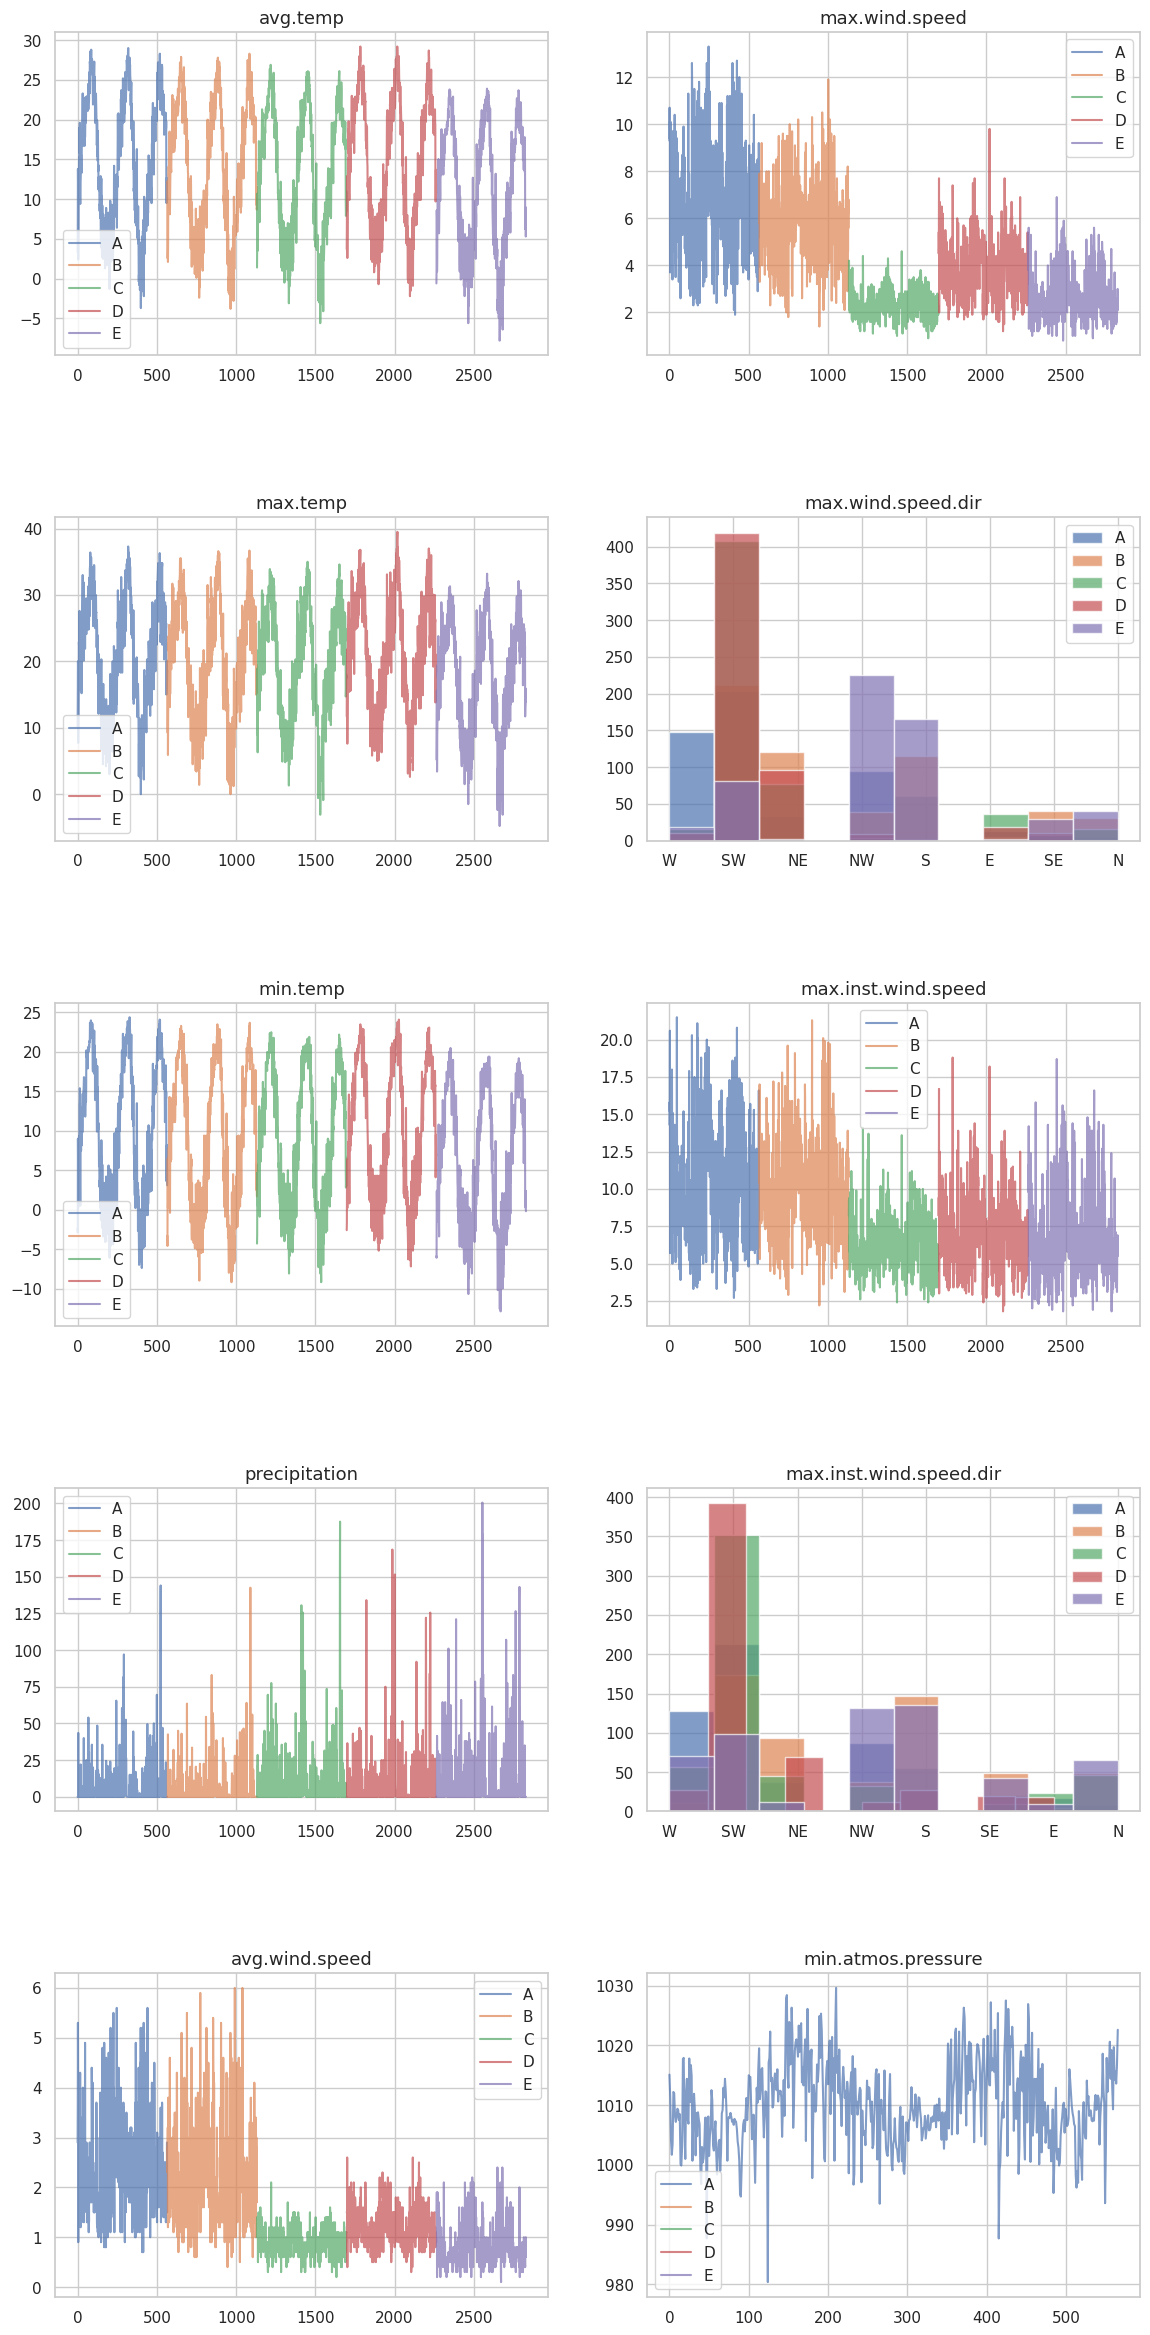

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(14, 30), dpi=100)

for i, col_name in enumerate(train_all_lvls.columns[2:]):
    if train_all_lvls[col_name].dtype == 'O':
        train_all_lvls.groupby('region')[col_name].hist(ax=axes[i%5][i//5], alpha=0.7); #범주형 5개 , alpha는 투명도 작을수록 투명해짐
        axes[i%5][i//5].legend(["A", "B", "C", "D", "E"]); #범례
    else:
        train_all_lvls.groupby('region')[col_name].plot(ax=axes[i%5][i//5], alpha=0.7);
        axes[i%5][i//5].legend();
    axes[i%5][i//5].set_title(f'{col_name}', fontsize=13);
    plt.subplots_adjust(hspace=0.5) #위아래 공간 얼마나 쓸건지
    # A,B / C,D,E 가 비슷해보인다.

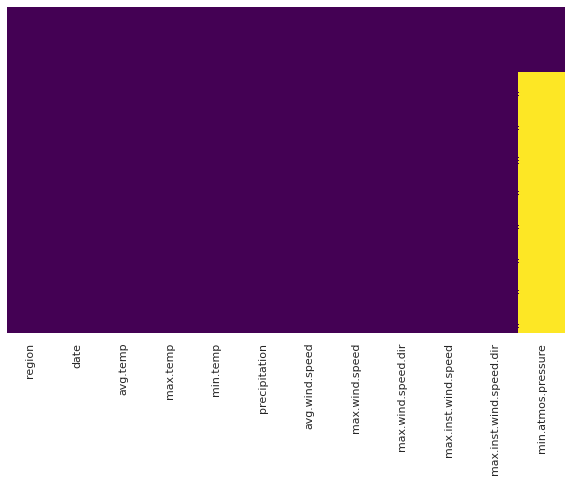

In [ ]:
#누락값 찾기
plt.figure(figsize=(10,6))
sns.heatmap(train_all_lvls.isnull(), yticklabels=False, cmap='viridis',cbar=False)

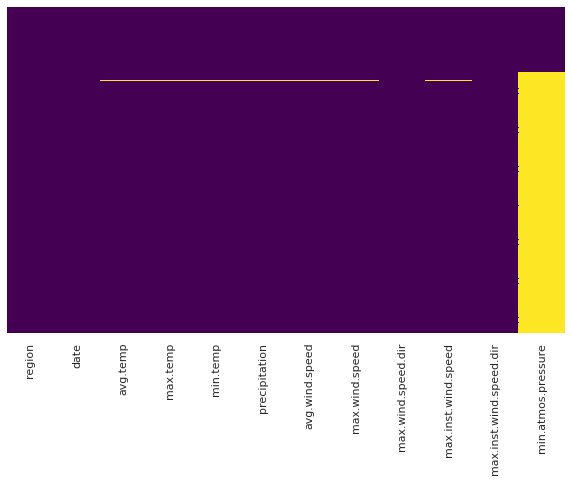

In [ ]:
#누락값 찾기
plt.figure(figsize=(10,6))
sns.heatmap(test_all_lvls.isnull(), yticklabels=False, cmap='viridis',cbar=False)

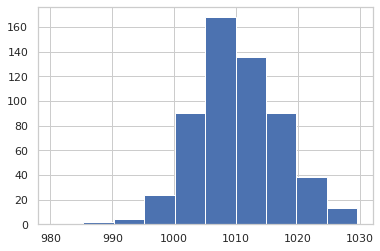

In [ ]:
#누락된 값을 어떻게 처리할까?
#결측값이 있는 열의 분포를 살펴보자
train_all_lvls['min.atmos.pressure'].hist();
#결측값 처리 방법 : https://daebaq27.tistory.com/43

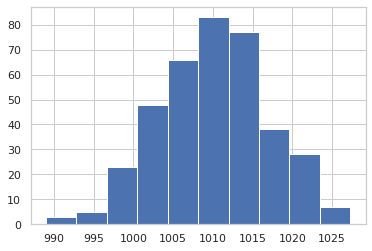

In [ ]:
test_all_lvls['min.atmos.pressure'].hist();

In [ ]:
#열의 분포가 정상이므로 누락된 데이터를 평균으로 대치한다.
mean_atmos = train_all_lvls['min.atmos.pressure'].mean()
train_all_lvls.fillna(mean_atmos, inplace=True)
train_all_lvls

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.100000
1,A,3134f4ff,5.7,13.7,-2.9,0.0,3.6,10.7,W,15.8,W,1011.300000
2,A,dbfaf910,13.8,20.0,9.0,0.0,5.3,9.4,SW,15.2,W,1004.200000
3,A,3aea0cf0,11.4,19.3,5.8,0.0,4.2,10.1,SW,20.6,SW,1001.700000
4,A,f0227f56,2.4,7.7,0.3,43.5,0.9,3.7,SW,5.7,SW,1003.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
2825,E,91b2797d,6.3,13.1,0.3,0.0,0.6,2.2,S,4.3,S,1010.216254
2826,E,b807fd87,6.2,13.5,0.3,0.0,0.8,2.3,SW,6.3,W,1010.216254
2827,E,8e0a48e0,9.0,15.9,2.4,0.0,0.6,2.4,NW,5.7,W,1010.216254
2828,E,9df85983,5.3,13.9,0.1,0.0,1.0,3.0,S,6.9,NW,1010.216254


In [ ]:
#열의 분포가 정상이므로 누락된 데이터를 평균으로 대치한다.
mean_atmos = test_all_lvls['min.atmos.pressure'].mean()
test_all_lvls.fillna(mean_atmos, inplace=True)
test_all_lvls

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure
0,A,b92d713a,5.0,11.9,0.7,0.0,3.6,11.9,NW,16.7,NW,1009.200000
1,A,18817005,2.9,9.1,-1.8,0.0,3.4,9.6,SW,15.4,SW,1013.600000
2,A,8e19dc3c,9.8,18.9,0.4,0.0,3.1,8.9,W,13.6,W,1002.600000
3,A,6f0929dc,13.4,21.2,6.1,0.0,3.4,8.8,SW,13.8,SW,1003.100000
4,A,c7506622,9.1,16.3,2.4,0.0,2.7,7.6,NW,11.9,NW,1011.900000
...,...,...,...,...,...,...,...,...,...,...,...,...
1885,E,01a1b150,6.9,9.5,4.3,1.5,0.3,1.2,S,2.7,SE,1010.120106
1886,E,90b49549,6.5,15.8,-0.1,0.0,0.6,2.2,SE,4.7,S,1010.120106
1887,E,15bc4979,7.9,10.3,3.5,9.5,0.3,1.7,SW,5.8,S,1010.120106
1888,E,b4104846,9.1,17.1,4.9,11.0,0.6,2.1,SW,5.8,NW,1010.120106


In [ ]:
#기능 전처리 및 엔지니어링
train_all_lvls = train_all_lvls.merge(labels_df, on="date") #데이터에 레이블을 추가해준다.
train_all_lvls

,region,date,avg.temp,max.temp,min.temp,precipitation,avg.wind.speed,max.wind.speed,max.wind.speed.dir,max.inst.wind.speed,max.inst.wind.speed.dir,min.atmos.pressure,label
0,A,229b70a3,3.3,10.2,-2.4,0.0,2.9,9.3,W,14.3,W,1015.100000,N
1,B,229b70a3,2.6,9.3,-3.3,0.0,2.8,6.3,NW,11.4,NW,1010.216254,N
2,C,229b70a3,1.4,9.0,-4.3,0.0,1.0,2.9,SW,8.2,N,1010.216254,N
3,D,229b70a3,3.7,11.7,-2.6,0.0,1.5,5.4,SW,9.4,S,1010.216254,N
4,E,229b70a3,-0.6,5.2,-5.9,0.0,1.5,3.8,NW,9.8,W,1010.216254,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,A,c9d4fe7c,10.0,18.7,3.1,0.0,1.5,5.2,SW,7.9,SW,1022.600000,L
2826,B,c9d4fe7c,8.9,18.4,1.7,0.0,1.7,5.6,S,11.1,SE,1010.216254,L
2827,C,c9d4fe7c,8.5,17.5,3.0,0.0,1.1,2.3,SW,5.6,SW,1010.216254,L
2828,D,c9d4fe7c,10.8,18.4,7.0,0.0,0.9,3.4,SW,5.5,SW,1010.216254,L


In [ ]:
train_all_lvls.select_dtypes('object').columns

Index(['region', 'date', 'max.wind.speed.dir', 'max.inst.wind.speed.dir',
       'label'],
      dtype='object')

In [ ]:
#대상 변수를 포함한 범주형 기능을 숫자 형식으로 변환해야 합니다.
#scikit-learn의 레이블 인코더 를 사용하여 이를 수행해 보겠습니다 .
le = LabelEncoder()
le.fit(train_all_lvls['label'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'H': 0, 'L': 1, 'N': 2}

이제 데이터를 더 긴 형식으로 피벗해야 합니다 . 즉, 영역이 열이 되는 대신 나머지 기능 에 대해 각 기능에 avg.temp_A, 와 같은 고유한 영역 이 있습니다.avg.temp_Bavg.temp_E
이렇게 하면 데이터가 모델을 구축하는 데 적합한 모양이 됩니다.

In [ ]:
train = train_all_lvls
train = train.pivot_table(index=["date", "label"], columns="region")
train = pd.DataFrame(train.to_records())
train.head()

,date,label,"('avg.temp', 'A')","('avg.temp', 'B')","('avg.temp', 'C')","('avg.temp', 'D')","('avg.temp', 'E')","('avg.wind.speed', 'A')","('avg.wind.speed', 'B')","('avg.wind.speed', 'C')",...,"('min.temp', 'A')","('min.temp', 'B')","('min.temp', 'C')","('min.temp', 'D')","('min.temp', 'E')","('precipitation', 'A')","('precipitation', 'B')","('precipitation', 'C')","('precipitation', 'D')","('precipitation', 'E')"
0,00173aec,N,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,0083f291,L,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,014cfe7b,N,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,01947c8e,N,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,0258884d,N,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0


In [ ]:
test = test_all_lvls
test = test.pivot_table(index=["date"], columns="region")
test = pd.DataFrame(test.to_records())
test.head()

,date,"('avg.temp', 'A')","('avg.temp', 'B')","('avg.temp', 'C')","('avg.temp', 'D')","('avg.temp', 'E')","('avg.wind.speed', 'A')","('avg.wind.speed', 'B')","('avg.wind.speed', 'C')","('avg.wind.speed', 'D')",...,"('min.temp', 'A')","('min.temp', 'B')","('min.temp', 'C')","('min.temp', 'D')","('min.temp', 'E')","('precipitation', 'A')","('precipitation', 'B')","('precipitation', 'C')","('precipitation', 'D')","('precipitation', 'E')"
0,0001f2fd,21.1,20.7,20.4,21.4,18.4,1.1,0.9,0.6,0.9,...,17.2,16.8,17.3,18.2,14.7,41.5,23.5,38.0,39.5,54.5
1,00177dc1,20.6,20.5,19.1,21.1,17.8,1.7,1.4,0.8,1.0,...,18.3,17.1,15.4,18.8,13.3,38.0,20.5,33.5,34.5,30.5
2,00b3a048,7.8,6.4,7.2,8.0,4.8,1.5,3.1,0.7,0.6,...,3.9,1.4,3.8,6.1,-0.2,4.0,8.0,4.5,11.5,8.0
3,013f131b,29.0,27.8,27.2,28.2,23.9,2.4,1.8,0.9,1.7,...,24.5,22.2,22.5,22.3,18.8,0.0,0.0,0.0,0.0,0.0
4,01a1b150,9.3,9.2,8.8,10.2,6.9,0.9,1.9,0.9,0.8,...,7.5,5.6,5.9,8.7,4.3,0.0,0.5,0.5,2.0,1.5


In [ ]:
#열 이름이 이상적이지 않으므로 수정하는 함수를 작성했습니다.

def replace_all(text):
    d = { "('": "", "', '": "_", "')" : "",}
    for i, j in d.items():
        text = text.replace(i, j)
    return text

# ('avg.temp', 'A') -> avg.temp_A

test_str = "('avg.temp', 'A')"
replace_all(test_str)

'avg.temp_A'

In [ ]:
train.columns = list(map(replace_all, train.columns)) #모든 컬럼명에 적용

In [ ]:
test.columns = list(map(replace_all, test.columns)) #모든 컬럼명에 적용

테스트 데이터에 대해 동일한 작업을 수행한 후에는 Train 데이터를 분할할 차례입니다.


In [ ]:
X, y = train.drop(["label", "date"], axis=1), train[["label"]].values.flatten() #train에서 label, date컬럼 뺀것을 X로 두고, label열은 y로 분할한다.
X

,avg.temp_A,avg.temp_B,avg.temp_C,avg.temp_D,avg.temp_E,avg.wind.speed_A,avg.wind.speed_B,avg.wind.speed_C,avg.wind.speed_D,avg.wind.speed_E,...,min.temp_A,min.temp_B,min.temp_C,min.temp_D,min.temp_E,precipitation_A,precipitation_B,precipitation_C,precipitation_D,precipitation_E
0,18.7,17.6,16.9,19.5,14.3,1.6,1.8,0.9,1.2,0.5,...,14.9,12.5,12.9,16.4,9.0,1.0,1.5,1.5,0.0,4.5
1,13.1,12.6,12.0,13.0,10.7,1.4,1.0,0.7,0.7,0.6,...,11.3,11.1,10.6,12.1,8.5,50.0,46.5,49.0,45.5,63.0
2,19.9,19.0,17.5,19.9,16.2,3.7,3.6,0.7,1.3,1.1,...,16.1,13.5,15.8,16.3,12.4,18.0,17.0,63.5,19.0,32.0
3,21.6,20.2,20.5,21.3,17.6,1.6,1.2,1.1,1.0,0.6,...,15.8,14.2,15.5,15.9,11.5,0.0,1.0,0.0,0.0,0.0
4,15.2,13.9,13.9,15.8,11.1,2.5,2.3,1.2,1.8,0.7,...,10.3,5.6,8.9,10.4,5.3,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,2.9,1.6,1.4,3.4,0.4,1.2,0.9,0.7,0.9,0.7,...,-4.0,-5.9,-2.8,-3.4,-5.9,0.0,0.0,0.0,0.0,0.0
562,2.9,2.9,3.9,2.9,0.2,1.6,3.9,1.0,0.7,0.3,...,1.7,1.4,1.9,1.0,-1.2,2.0,1.0,2.0,4.0,8.0
563,9.8,8.9,9.0,10.2,6.3,1.9,1.5,1.4,1.5,0.9,...,1.5,-0.1,2.0,2.5,-1.9,0.0,0.0,0.0,0.0,0.0
564,10.4,8.1,7.1,11.0,5.7,4.3,4.6,0.9,2.0,1.7,...,3.4,1.5,-0.6,3.2,-1.6,0.0,3.5,5.5,0.0,1.5


In [ ]:
# 변환된 X로 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size = 0.25, random_state = 100)

데이터 불균형이 너무 심하므로 SMOTE를 사용하여 데이터를 증강시켜주자

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (424, 40) (424,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (813, 40) (813,)
SMOTE 적용 후 레이블 값 분포: 
 L    271
N    271
H    271
dtype: int64


이제 LightGBM모델을 구축하자!

In [ ]:
lgb=lgb.LGBMClassifier()#Define the parameters

AttributeError: ignored

In [ ]:
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20], 'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}#Define the scoring

In [ ]:
clf=GridSearchCV(lgb,parameters,scoring='accuracy') 
clf.fit(X=X_train, y=y_train)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [-1, 5, 10, 20],
                         'min_child_samples': [5, 10, 15],
                         'num_leaves': [20, 40, 60, 80, 100],
                         'reg_alpha': [0, 0.01, 0.03]},
             scoring='accuracy')

In [ ]:
print(clf.best_params_) 
predicted=clf.predict(X_test)

{'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 10, 'num_leaves': 40, 'reg_alpha': 0}


In [ ]:
print('Classification of the result is:') 
print(accuracy_score(y_test, predicted))

Classification of the result is:
0.5985915492957746


불균형 데이터 세트인 경우 99%정확도는 의미가 없을수 있다. 따라서 정밀도, 재현율 및 confusion matrix같은 더 적합한 메트릭이 필요하다.

Confusion matrix, without normalization
[[ 4  4  7]
 [ 2 16 26]
 [ 1 17 65]]
Normalized confusion matrix
[[0.26666667 0.26666667 0.46666667]
 [0.04545455 0.36363636 0.59090909]
 [0.01204819 0.20481928 0.78313253]]


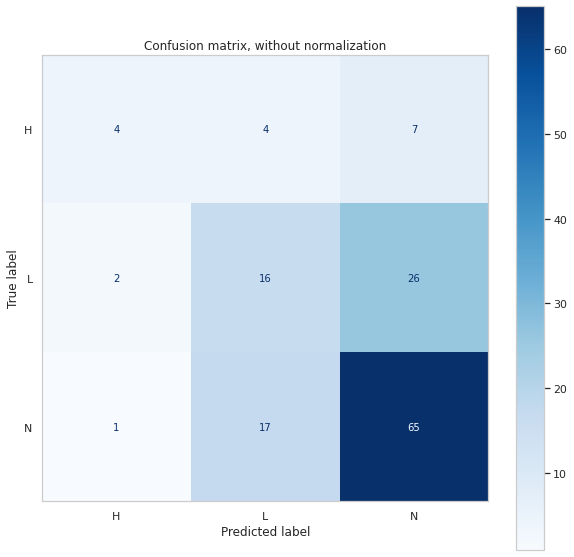

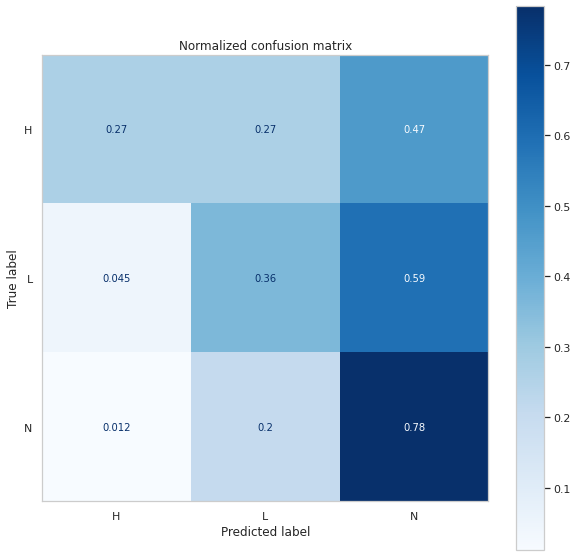

In [ ]:
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))

    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test, #
        y_test, #
        display_labels=class_names, #
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

In [ ]:
print(classification_report(predicted, y_test))

              precision    recall  f1-score   support

           H       0.27      0.57      0.36         7
           L       0.36      0.43      0.40        37
           N       0.78      0.66      0.72        98

    accuracy                           0.60       142
   macro avg       0.47      0.56      0.49       142
weighted avg       0.65      0.60      0.62       142



불균형이 아주 조금 해결된것을 알 수 있다. 

In [ ]:
#테스트 데이터에 대한 예측
#우리는 간단한 모델을 만들었다. 테스트 데이터에서 예측할 시간이다.
X = test.drop('date', axis=1)#쓸모없는 date열을 지운다.

In [ ]:
test_preds = clf.predict(X)
submission_df = pd.concat([test['date'], pd.DataFrame(test_preds, columns=['label'])], axis=1)
submission_df.head()

,date,label
0,0001f2fd,L
1,00177dc1,N
2,00b3a048,L
3,013f131b,N
4,01a1b150,L
